## Collection of terrible Graphs.
Graphs are plots of model based dyna implementation, without any annotations bedcause I am lazy.


In [1]:
import jax
import matplotlib.pyplot as plt

from dyna.training import make_dyna_train_fn 
from model_based.train import EquiModel, Model
from dyna.types import ActorCriticHyperParams, DynaHyperParams, TransitionModelHyperParams 


In [12]:
NUM_UPDATES = 5
TM_LR = 1e-4
AC_LR = 3.5e-4
NUM_SEEDS = 30
NUM_ENVS = 4
TM_EPOCHS = 3
PR = 0.2

ac_hyp = ActorCriticHyperParams(NUM_UPDATES=5, NUM_EPOCHS=4, LR=AC_LR, PRIV_NUM_TIMESTEPS=512)
eqi_hyp = TransitionModelHyperParams(MODEL_FN = EquiModel,LR=TM_LR, NUM_EPOCHS=TM_EPOCHS, )
tm_hyp = TransitionModelHyperParams(MODEL_FN=Model,LR=TM_LR, NUM_EPOCHS=TM_EPOCHS, )
no_m_hyp = TransitionModelHyperParams(USE_MODEL=False, LR=TM_LR, NUM_EPOCHS=TM_EPOCHS, )
mf_hyp = DynaHyperParams(ac_hyp, no_m_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)
dyna_hyp = DynaHyperParams(ac_hyp, tm_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS )
equi_hyp = DynaHyperParams(ac_hyp, eqi_hyp,NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, NUM_SEEDS)
results= []
hyp = [mf_hyp, dyna_hyp, equi_hyp]
names = ['mf', 'dyna', 'equi-dyna']
for h in hyp[:]:
    train_fn = jax.vmap(make_dyna_train_fn(h))
    result = train_fn(rngs)
    results.append(result)
    

    

Model Params: 13124
Model Params: 13124
Model Params: 13124


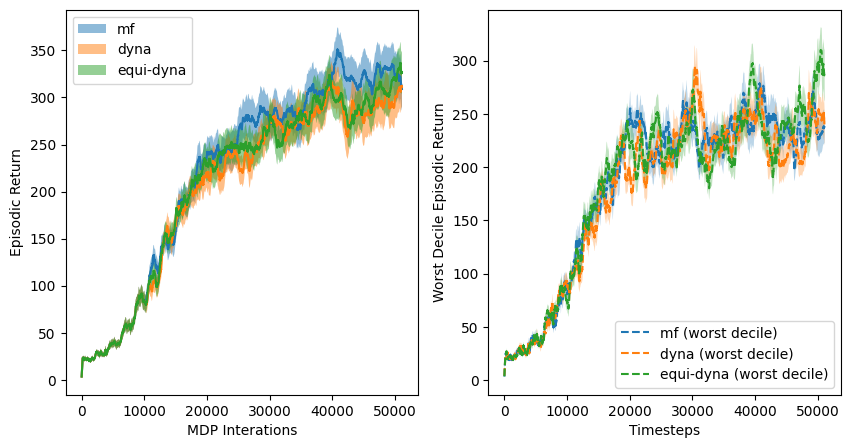

In [13]:
import numpy as np
import jax.numpy as jnp
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), "valid") / w
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for res, name in zip(results, names):
    _, info = res
    traj = info[1]

    acting_returns = traj.info["returned_episode_returns"]
    acting_returns = acting_returns.reshape(NUM_SEEDS, -1)
    acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
    acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
    acting_returns_mean = moving_average(acting_returns_mean)
    acting_returns_std = moving_average(acting_returns_std)
    lower = acting_returns_mean - acting_returns_std
    upper = acting_returns_mean + acting_returns_std
    x = jnp.arange(len(acting_returns_mean))
    ax[0].plot(acting_returns_mean, )
    ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.5,  label=name)
    ax[0].legend()    
    ax[0].set_xlabel("MDP Interations")
    ax[0].set_ylabel("Episodic Return")
    cumulative_returns = np.cumsum(acting_returns.reshape(NUM_SEEDS, -1), axis=1)[:, -1]
    assert cumulative_returns.shape == (NUM_SEEDS,), f"{cumulative_returns.shape}"
    worst_decile = np.quantile(cumulative_returns, 0.3)
    worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
    worst_std = acting_returns[cumulative_returns < worst_decile].std(
        axis=0
    ) / np.sqrt(NUM_SEEDS)
    worst_upper = worst_mean + worst_std
    worst_lower = worst_mean - worst_std
    ax[1].plot(
        x,
        moving_average(worst_mean),
        label=f"{name} (worst decile)",
        linestyle="--",
    )
    ax[1].fill_between(
        x,
        moving_average(worst_lower),
        moving_average(worst_upper),
        alpha=0.3,
    )
    ax[1].set_xlabel("Timesteps")
    ax[1].set_ylabel("Worst Decile Episodic Return")

ax[0].legend()
ax[1].legend()
fig.savefig("plots.png")




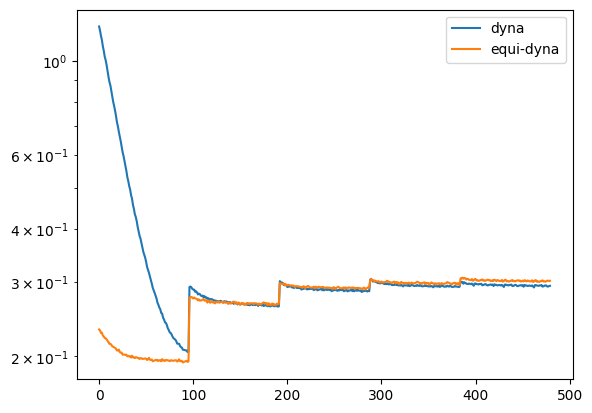

In [14]:
for res, name in zip(results[1:], names[1:]):
    _, info = res
    m_loss= info[-1]
    plt.semilogy(m_loss.mean(axis=0).reshape(-1),  label=name)
plt.legend()